# 📚 Matrix Compression Tutorial: LU, SVD, and DCT

Matrix factorizations aren't just useful for solving equations — they can also reveal structure that helps us **compress data** efficiently. In this notebook, we'll explore three different approaches to matrix compression:

- **LU decomposition** with thresholding: a baseline method that breaks a matrix into triangular factors,
- **SVD (Singular Value Decomposition)** with rank truncation: a mathematically optimal method for low-rank approximation,
- **DCT (Discrete Cosine Transform)** with coefficient thresholding: a fast, practical method used in real-world applications like JPEG compression.

Along the way, you'll:
- Construct and visualize the DCT basis manually to build intuition,
- Analyze reconstruction error and storage cost for each method,
- Learn to compute realistic compression ratios based on byte-level assumptions,
- Compare all three methods side by side in terms of efficiency and accuracy.

By the end, you'll understand the trade-offs between these techniques and how to decide which one is best suited to a given compression task.


___

Here we'll load some package and choose a matrix to compress.  The two possibilites are 'random' and 'image'.  Start with 'image' to see how compression can exploit structure.  Then return and change to 'random'.

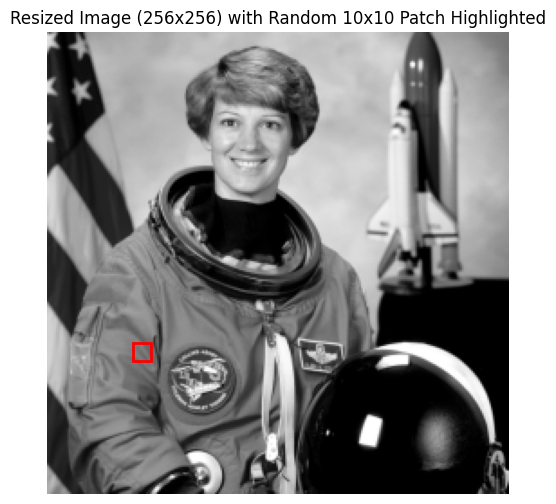

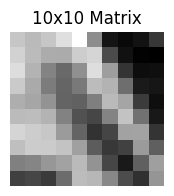

In [24]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lu
from scipy.fftpack import dct, idct
from skimage import data, color, transform
from matplotlib.patches import Rectangle

matrix_choice = 'image' # or 'image'

if matrix_choice == 'random':
    # Random matrix to compress
    A = np.random.randn(10, 10)
else:
    # Load and preprocess the image
    image = color.rgb2gray(data.astronaut())  # Example image
    image_resized = transform.resize(image, (256, 256), anti_aliasing=True)

    # Define patch size
    patch_size = 10

    # Pick random top-left corner for the patch
    np.random.seed(0)  # Optional: for reproducibility
    row_start = np.random.randint(0, 256 - patch_size)
    col_start = np.random.randint(0, 256 - patch_size)

    # Extract the patch
    patch = image_resized[row_start:row_start+patch_size, col_start:col_start+patch_size]

    # Display the resized image with a red rectangle around the patch
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(image_resized, cmap='gray')
    # Add rectangle
    rect = Rectangle((col_start, row_start), patch_size, patch_size,
                    linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.set_title('Resized Image (256x256) with Random 10x10 Patch Highlighted')
    ax.axis('off')
    plt.show()
    
    # Convert the patch to a matrix
    A = patch.copy()

# Display the matrix or extracted patch
plt.figure(figsize=(2,2))
plt.imshow(A, cmap='gray')
plt.title('10x10 Matrix')
plt.axis('off')
plt.show()

fro_norm_A = np.linalg.norm(A, 'fro')

## LU Decomposition and Compression

We start by exploring **LU decomposition** as a tool for matrix compression.

In LU decomposition, a matrix $A$ is factored into three matrices:
$$
A = P L U
$$
where:
- $P$ is a **permutation matrix** (to handle row swaps),
- $L$ is a **lower triangular matrix** with ones on the diagonal,
- $U$ is an **upper triangular matrix**.

This factorization allows us to express any linear transformation by a **sequence of simpler transformations**:
1. **Apply $P^T$** (permute the rows of a vector),
2. **Apply $L$** (forward substitution),
3. **Apply $U$** (back substitution).

Because $L$ and $U$ are triangular, they are easier to store and apply than a full dense matrix.  
In fact, if many entries in $L$ and $U$ are zero or small, **we can think about compressing $A$** by keeping only the significant entries!

---

### Compression Strategy

To compress a matrix using LU decomposition, we:
- Perform the LU factorization of $A$.
- **Threshold** small entries in $L$ and $U$ by setting them to zero.
- **Store** only the significant (nonzero) entries, along with their positions.

This approach is similar in spirit to the matrix compression strategies you will see below with the DCT and SVD:
- **Change the representation** of $A$ into a more structured form,
- **Simplify** by discarding small or less important components,
- **Estimate** compression ratios realistically by accounting for the storage of both **values and indices**.

We will use the **byte size** needed to store the compressed data compared to the original matrix to compute realistic compression ratios.

---



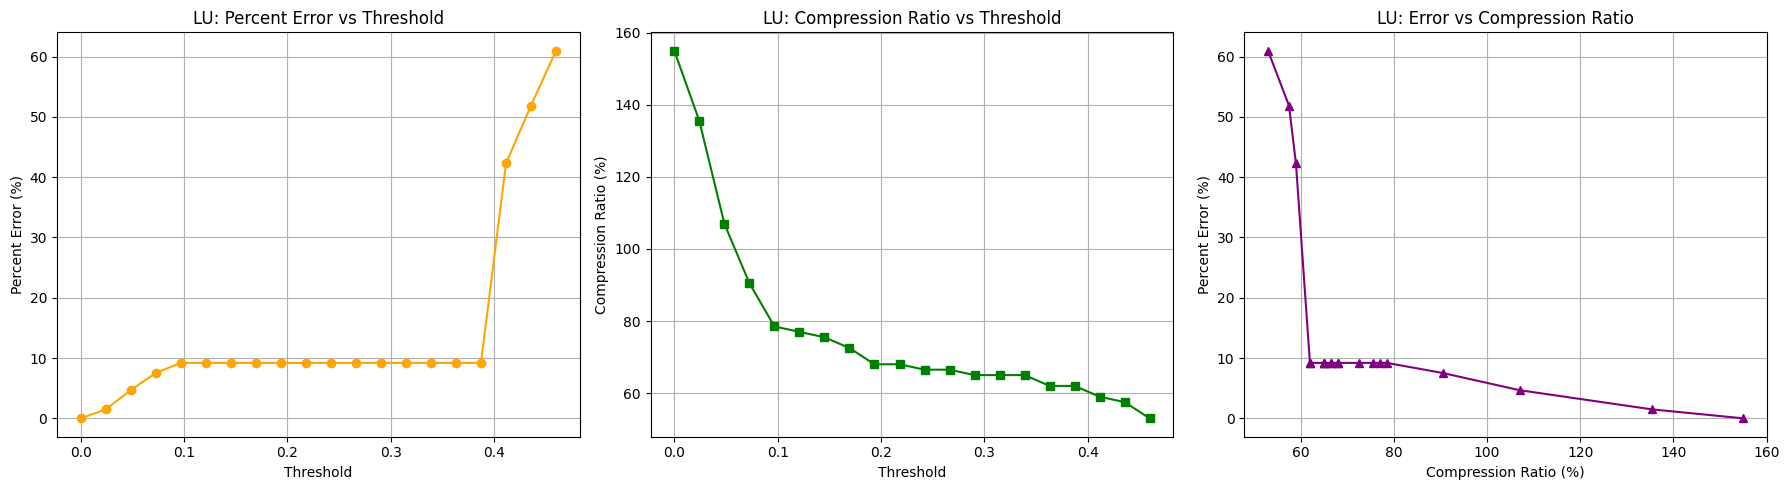

In [25]:
from scipy.linalg import lu
import numpy as np
import matplotlib.pyplot as plt

# Step 1: LU decomposition with pivoting
# scipy.linalg.lu returns P, L, U such that A = P @ L @ U
P, L, U_lu = lu(A)

def threshold_matrix(M, threshold):
    """
    Zero out all entries in the matrix below a specified magnitude threshold.
    This simulates compression by discarding small values.
    """
    M_new = M.copy()
    M_new[np.abs(M_new) < threshold] = 0
    return M_new

def compression_ratio_lu(L, U):
    """
    Estimate compression ratio based on nonzero entries in L and U.

    - L is lower triangular (excluding 1s on diagonal)
    - U is upper triangular (including diagonal)
    - We assume each stored value needs 4 bytes, and each (row, col) index pair needs 4 bytes (2 per index)
    - Permutation vector (for P) requires n * 2 bytes
    """
    n = L.shape[0]

    # Count nonzeros in L below the diagonal (we assume diagonal 1s are implicit and not stored)
    L_lower = np.tril(L, k=-1)
    nonzeros_L = np.count_nonzero(L_lower)

    # Count nonzeros in U (including diagonal)
    nonzeros_U = np.count_nonzero(U)

    # Estimate storage:
    # - Each value: 4 bytes
    # - Each position (row, col): 4 bytes total (2 bytes each)
    total_values = nonzeros_L + nonzeros_U
    total_indices = total_values

    # Add cost for permutation vector (n entries, 2 bytes each)
    permutation_bytes = n * 2

    compressed_bytes = total_values * 4 + total_indices * 2 + permutation_bytes
    original_bytes = n * n * 4  # assume original matrix is float32

    return compressed_bytes / original_bytes

# Step 2: Sweep through thresholds to simulate compression
top_thresh = 0.1 * fro_norm_A  # upper threshold limit based on norm
thresholds = np.linspace(0, top_thresh, 20)  # 20 evenly spaced thresholds
errors_percent_lu = []
compression_ratios_lu = []

for thresh in thresholds:
    # Apply threshold to L and U separately
    L_thresh = threshold_matrix(L, thresh)
    U_thresh = threshold_matrix(U_lu, thresh)

    # Reconstruct approximation A ≈ P @ L @ U
    A_approx = P @ L_thresh @ U_thresh

    # Compute percent reconstruction error
    error = np.linalg.norm(A - A_approx, 'fro')
    errors_percent_lu.append(100 * error / fro_norm_A)

    # Compute realistic compression ratio
    compression_ratios_lu.append(100 * compression_ratio_lu(L_thresh, U_thresh))

# Step 3: Plot results

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Error vs Threshold
axs[0].plot(thresholds, errors_percent_lu, marker='o', color='orange')
axs[0].set_title('LU: Percent Error vs Threshold')
axs[0].set_xlabel('Threshold')
axs[0].set_ylabel('Percent Error (%)')
axs[0].grid(True)

# Plot 2: Compression Ratio vs Threshold
axs[1].plot(thresholds, compression_ratios_lu, marker='s', color='green')
axs[1].set_title('LU: Compression Ratio vs Threshold')
axs[1].set_xlabel('Threshold')
axs[1].set_ylabel('Compression Ratio (%)')
axs[1].grid(True)

# Plot 3: Tradeoff between Error and Compression Ratio
axs[2].plot(compression_ratios_lu, errors_percent_lu, marker='^', color='purple')
axs[2].set_title('LU: Error vs Compression Ratio')
axs[2].set_xlabel('Compression Ratio (%)')
axs[2].set_ylabel('Percent Error (%)')
axs[2].grid(True)

plt.tight_layout()
plt.show()


### Visualizing the Compressed Matrix

The code below shows the original matix and the compressed matrix with threshold 0.07 (compression ratio about 90%).  You can see that it's not a very faithful approximation.

### Interpreting the LU Compression Results

These three plots summarize the effect of thresholding small entries in the $L$ and $U$ matrices:

- **Left plot**: As the threshold increases, the reconstruction error also increases — especially between thresholds of 0.03 and 0.07 — since we are discarding more information from the factorization. However, notice that the error **plateaus after about 0.1**. This suggests that the remaining values being removed are already small or irrelevant, and their contribution to the reconstruction is minimal.

- **Middle plot**: The compression ratio improves as we increase the threshold, meaning we’re storing fewer values. The improvement slows down once most of the smallest values have already been discarded.

- **Right plot**: This plot shows the classic trade-off: as we compress more, we lose accuracy. The curve bends because the most "important" structure in the matrix has already been lost by the time the compression reaches around 80–90%.

Overall, this method allows us to discard small, non-critical values while preserving the overall structure of the matrix — up to a point. Beyond that, compression doesn't improve much and error stops increasing because there's little meaningful information left to remove.

Note: Even without any thresholding (i.e., full LU), the compression ratio is **above 100%**, meaning LU stores *more* data than the original dense matrix. This is due to the overhead of storing both values and their positions (as well as the permutation vector), which makes LU less efficient than other methods explored below.

---

In the next sections, you'll explore two more powerful approaches to matrix compression — **SVD** and **DCT** — which often yield better accuracy-to-compression tradeoffs, especially for matrices with structure or smoothness.



### 2. SVD Decomposition and Compression

The Singular Value Decomposition (SVD) expresses a matrix as a sequence of three transformations:

$$
A = U \Sigma V^\top
$$

- $V^\top x$ transforms the input vector $x$ into a new coordinate system (right singular vectors).
- $\Sigma$ scales each coordinate according to the importance (strength) of that direction (singular values).
- $U$ maps the result to the output space (left singular vectors).

So applying $A$ to a vector $x$ can be interpreted as:

$$
A x = U \left( \Sigma \left( V^\top x \right) \right)
$$

---

### Truncated SVD for Compression

The full SVD uses all $r = \text{rank}(A)$ singular values.  
But we can keep only the top $k$ largest singular values to get a **low-rank approximation**:

$$
A_k = U_k \Sigma_k V_k^\top
$$

This is called **truncated SVD**, and it gives the best possible approximation (in Frobenius norm) of rank $k$. This result is known as the **Eckart–Young–Mirsky theorem**.

---

### What Needs to Be Stored

To store the compressed matrix $A_k$, we need to save:
- $U_k$: an $n \times k$ matrix (first $k$ columns of $U$)
- $\Sigma_k$: a $k \times k$ diagonal matrix (top $k$ singular values)
- $V_k$: a $k \times n$ matrix (first $k$ rows of $V^\top$)

This totals:

$$
\text{Storage} = n \cdot k + k + k \cdot n = k(2n + 1)
$$

We compute the **compression ratio** by comparing the number of bytes used to store this truncated representation to the number of bytes in the original matrix.

---

### Summary

- SVD lets us break a matrix into interpretable transformations.
- Truncating the SVD reduces storage while still capturing the most important structure.
- This is useful for compressing data, speeding up computations, and revealing patterns in matrices.



---

### See it in code

In this cell, we use the Singular Value Decomposition (SVD) to compress a matrix by keeping only the largest $k$ singular values. This gives us a rank-$k$ approximation $A_k$ that captures the most important structure in the original matrix $A$.

For each value of $k$, we:
- Construct the best low-rank approximation using the top $k$ singular values,
- Measure the reconstruction error compared to the original matrix,
- Estimate how many bytes would be needed to store the compressed form.

Finally, we plot how the reconstruction error and compression ratio change as we vary $k$.

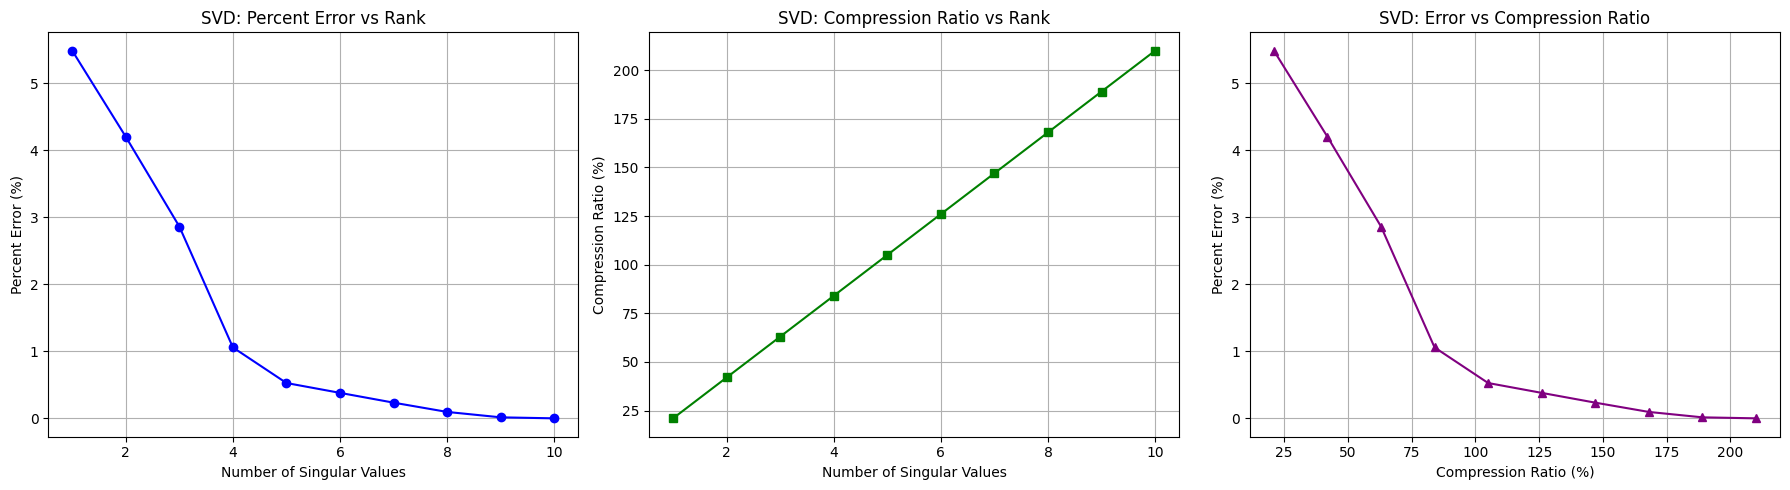

In [26]:
# Step 1: Compute the full SVD of A
# A = U Σ Vᵀ, where U and V are orthonormal, and Σ contains the singular values
U, S, VT = np.linalg.svd(A, full_matrices=False)

def svd_approx(U, S, VT, k):
    """
    Construct the best rank-k approximation of A using the top k singular values.

    Parameters:
    - U, S, VT: full SVD of A
    - k: number of singular values (rank) to retain

    Returns:
    - A_k: the reconstructed low-rank approximation A_k ≈ A
    """
    # Keep only the top k singular values (zero out the rest)
    S_k = np.zeros_like(S)
    S_k[:k] = S[:k]

    # Reconstruct the matrix using U * S_k @ VT
    # S_k is broadcast along columns of U (same as U @ np.diag(S_k) @ VT)
    return (U * S_k) @ VT

def compression_ratio_svd(k, n, bytes_per_float=4):
    """
    Estimate compression ratio for rank-k SVD approximation.

    Assumes:
    - We store U_k (n x k), Σ_k (length k), and V_k (k x n)
    - Each float requires 4 bytes by default (float32)
    """
    original_bytes = n * n * bytes_per_float
    compressed_bytes = (2 * n * k + k) * bytes_per_float  # U_k, V_k, and Σ_k
    return compressed_bytes / original_bytes

# Step 2: Try different values of k (rank) and record error/compression
ranks = range(1, 11)
errors_percent_svd = []
compression_ratios_svd = []

for k in ranks:
    # Build rank-k approximation of A
    A_k = svd_approx(U, S, VT, k)

    # Compute relative reconstruction error in percent
    error = np.linalg.norm(A - A_k, 'fro')
    errors_percent_svd.append(100 * error / fro_norm_A)

    # Compute estimated compression ratio in percentage
    cr = compression_ratio_svd(k, A.shape[0])
    compression_ratios_svd.append(100 * cr)

# Step 3: Plot results

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: How error changes with rank
axs[0].plot(ranks, errors_percent_svd, marker='o', color='blue')
axs[0].set_title('SVD: Percent Error vs Rank')
axs[0].set_xlabel('Number of Singular Values')
axs[0].set_ylabel('Percent Error (%)')
axs[0].grid(True)

# Plot 2: How compression ratio changes with rank
axs[1].plot(ranks, compression_ratios_svd, marker='s', color='green')
axs[1].set_title('SVD: Compression Ratio vs Rank')
axs[1].set_xlabel('Number of Singular Values')
axs[1].set_ylabel('Compression Ratio (%)')
axs[1].grid(True)

# Plot 3: Tradeoff between error and compression
axs[2].plot(compression_ratios_svd, errors_percent_svd, marker='^', color='purple')
axs[2].set_title('SVD: Error vs Compression Ratio')
axs[2].set_xlabel('Compression Ratio (%)')
axs[2].set_ylabel('Percent Error (%)')
axs[2].grid(True)

plt.tight_layout()
plt.show()


### Interpreting the SVD Compression Results

These plots show how well truncated SVD performs when we keep only the top $k$ singular values:

- **Left plot**: As we increase the number of singular values (i.e., the rank), the reconstruction error drops rapidly. Most of the important structure in the matrix is captured in just the first few singular values — a key advantage of SVD for compression.

- **Middle plot**: The compression ratio grows linearly with rank because each additional singular value increases the number of values we need to store. Even so, the compressed version often requires less storage than the full matrix — especially at low ranks.

- **Right plot**: This plot shows the trade-off between accuracy and compression. We get significant error reduction early on, with diminishing returns after about 5 or 6 singular values. Beyond that point, compression becomes less efficient: we use more storage for smaller and smaller improvements.

SVD excels when the matrix has low-rank structure — that is, when most of its "energy" is concentrated in a few directions. This is common in many natural signals, images, and scientific datasets.

---

### Visualizing the Compression Quality

Here we compare the original matrix and its rank-3 approximation (3 singular values).  The compressed matrix requires about 70% of the storage as the orginal.

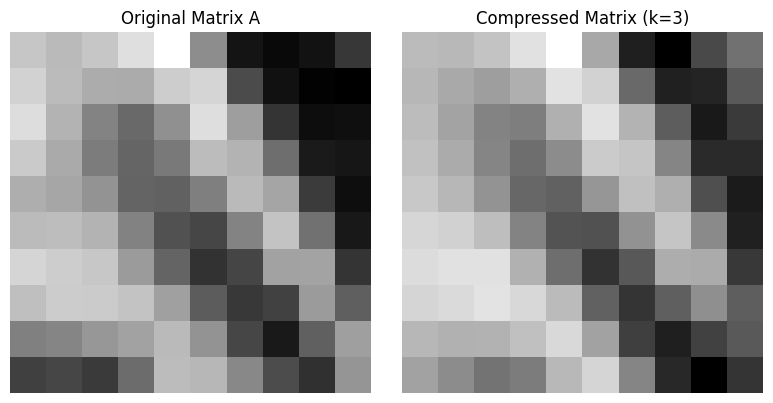

In [27]:
# Compress the matrix using 3 singular values
A_compressed_2 = svd_approx(U, S, VT, k=3)

# Plot the original and compressed matrices
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(A, cmap='gray')
axs[0].set_title('Original Matrix A')
axs[0].axis('off')

axs[1].imshow(A_compressed_2, cmap='gray')
axs[1].set_title('Compressed Matrix (k=3)')
axs[1].axis('off')

plt.tight_layout()
plt.show()


---

### Next: DCT-Based Compression

SVD gives the **best possible low-rank approximation**, but it requires computing and storing full orthogonal matrices. In the next section, we'll explore a faster alternative based on the **Discrete Cosine Transform (DCT)**.

Like SVD, DCT transforms a matrix into a new basis where much of the energy is concentrated in just a few components — but it does so using only predefined cosine basis vectors. This makes it ideal for fast compression tasks like image encoding, and we'll see how it compares to LU and SVD in both accuracy and storage.

## 3. DCT-Based Compression (JPEG-like Compression)

### Discrete Cosine Transform (DCT)

Just like the SVD, we can also think of the DCT as a sequence of transformations:

$$
A = C Y C^T
$$

where:
- $C$ is the DCT matrix containing basis vectors made of cosine functions,
- $Y = C^T A C$ are the DCT coefficients (the matrix in the cosine basis).

Applying $A$ to a vector $x$ can be interpreted as:

$$
A x = C ( Y (C^T x) )
$$

**Interpretation:**
1. $C^T x$ transforms the vector into a frequency-based cosine basis.
2. $Y$ acts on the coefficients in frequency space.
3. $C$ brings the result back to the original space.

This is very similar to the transformation view we discussed with the SVD!

---

### Why DCT for Compression?

The DCT has a powerful property: for smooth signals and images, most of the signal's energy is concentrated in a few low-frequency cosine terms.  
This means we can compress the matrix by:
- Transforming it into DCT space,
- Throwing away small coefficients (thresholding),
- Reconstructing an approximate version of the matrix.

This basic idea is how JPEG image compression works internally (although JPEG uses block-wise DCT and some additional steps).

---

### Building the DCT Matrix

Before we can apply DCT-based compression, we need to construct the DCT matrix $C$.

Each **column** of $C$ is a cosine basis vector with a different frequency, starting from low-frequency (smooth) waves and moving toward higher-frequency oscillations.

We can define the DCT matrix as:

$$
C_{k,n} = 
\begin{cases}
\sqrt{\frac{1}{N}} & \text{if } k=0 \\
\sqrt{\frac{2}{N}} \cos\left(\frac{\pi (2n+1)k}{2N}\right) & \text{if } k>0
\end{cases}
$$

where $k$ indexes the frequency and $n$ indexes the position.

In the next cell, we'll build and visualize the first few rows of the DCT matrix to see how the basis functions behave.



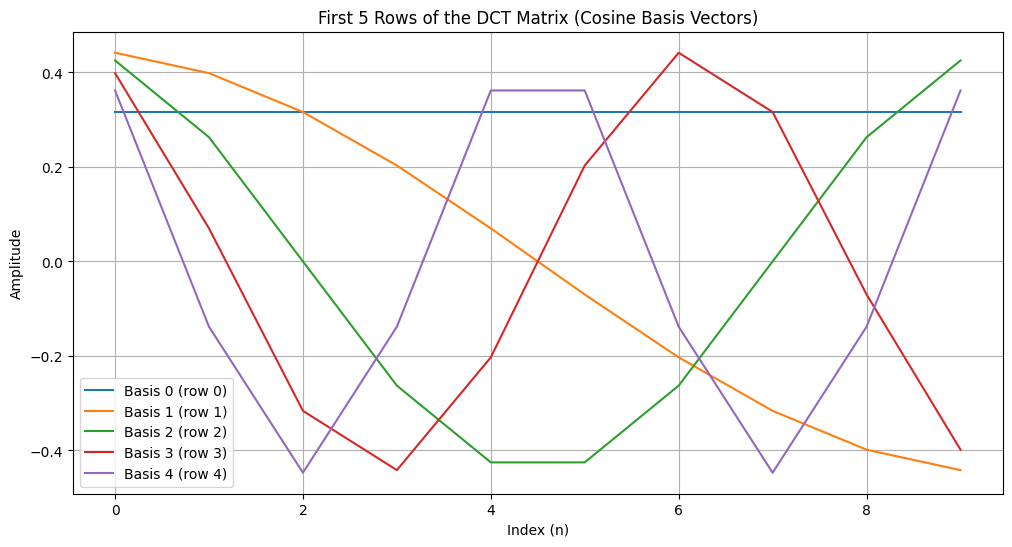

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def dct_matrix(N):
    """
    Build the orthonormal DCT (Type-II) matrix of size N x N.

    Each column of C is a discrete cosine basis vector.
    Basis vectors start from low-frequency (smooth) and move to high-frequency (rapid oscillations).
    """
    C = np.zeros((N, N))
    for k in range(N):         # k indexes the frequency (basis vector index)
        for n in range(N):     # n indexes the position (sample index)
            if k == 0:
                C[k, n] = np.sqrt(1 / N)
            else:
                C[k, n] = np.sqrt(2 / N) * np.cos(np.pi * (2 * n + 1) * k / (2 * N))
    return C

# Choose the size of the matrix
N = 10
C = dct_matrix(N)

# Plot the first few DCT basis vectors
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(C[i], label=f'Basis {i} (row {i})')
plt.title('First 5 Rows of the DCT Matrix (Cosine Basis Vectors)')
plt.xlabel('Index (n)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


### DCT-Based Matrix Compression

Now that we have built the DCT matrix $C$, we can use it to compress a matrix $A$.

The process follows the same sequence of transformations we discussed earlier:
1. **Apply the 2D DCT**: transform $A$ into the DCT (frequency) basis by computing $Y = C^\top A C$.
2. **Threshold small coefficients**: set small values in $Y$ to zero, keeping only the most important frequency components.
3. **Apply the inverse DCT**: reconstruct an approximation of $A$ from the thresholded DCT coefficients, using $A_{\text{reconstructed}} = C Y_{\text{thresh}} C^\top$.

After reconstructing, we will estimate:
- The **compression ratio**, based on how many nonzero DCT coefficients we stored.
- The **reconstruction error**, measured using the Frobenius norm.

Finally, we'll visualize the original matrix and the reconstructed (compressed) version side by side.

Compression Ratio (DCT): 106.00%
Percent Error (DCT): 1.9014%


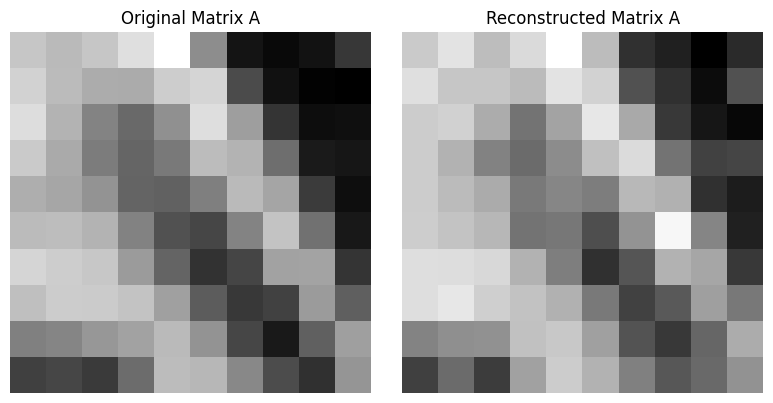

In [ ]:
# Step 1: Apply 2D DCT using an explicit DCT matrix
Y = C.T @ A @ C  # DCT of the matrix A

# Step 2: Zero out small coefficients using a threshold
def dct_threshold(Y, threshold):
    Y_new = Y.copy()
    Y_new[np.abs(Y_new) < threshold] = 0
    return Y_new

Y_thresholded = dct_threshold(Y, 0.025)

# Step 3: Inverse DCT using DCT matrix
A_reconstructed = C @ Y_thresholded @ C.T

# Step 4: Estimate compression ratio using bytes
def compression_ratio_dct(Y_thresh, block_size, bytes_per_float=4, bytes_per_index=2):
    """
    Compute compression ratio assuming we store:
    - each value as float32 (4 bytes)
    - each coefficient's row+col position (2 bytes each)
    """
    k = np.count_nonzero(Y_thresh)
    original_bytes = block_size * block_size * bytes_per_float
    compressed_bytes = k * (bytes_per_float + 2 * bytes_per_index)
    return 100 * compressed_bytes / original_bytes  # as percentage

CR = compression_ratio_dct(Y_thresholded, N)
print(f'Compression Ratio (DCT): {CR:.2f}%')

# Step 5: Compute percent reconstruction error
error_dct = np.linalg.norm(A - A_reconstructed, 'fro') / fro_norm_A * 100
print(f'Percent Error (DCT): {error_dct:.4f}%')

# Step 6: Visualize original and reconstructed matrices
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(A, cmap='gray')
axs[0].set_title('Original Matrix A')
axs[0].axis('off')

axs[1].imshow(A_reconstructed, cmap='gray')
axs[1].set_title('Reconstructed Matrix A')
axs[1].axis('off')

plt.tight_layout()
plt.show()


Using just 38% of the orginal storage we get a reasonable approximation to the original matrix.


## Fast DCT Compression


This approach performs the same conceptual steps as before — transforming to the DCT basis, thresholding small components, and reconstructing — but it does so **much more efficiently**. Instead of explicitly constructing the DCT matrix $C$, we use `scipy.fftpack.dct`, which computes the DCT using a fast algorithm similar to the FFT. This greatly reduces computation time while still implementing the transformation:
$$
Y = C A C^\top
$$
behind the scenes.  It also means that we don't have to store the $C$ matrix!


Here's what happens:

1. **Apply the 2D DCT**:  
   We transform the matrix $A$ into the DCT (frequency) basis by applying the 1D DCT along rows and then along columns:
   $$
   Y = \text{DCT}_{\text{cols}}( \text{DCT}_{\text{rows}}(A) )
   $$
   This is equivalent to computing $Y = C A C^\top$ in our earlier framework.

2. **Threshold small coefficients**:  
   After transforming into the DCT basis, many of the entries in $Y$ are small.  
   We set all entries smaller than a chosen threshold to zero:
   $$
   Y_{\text{thresh}}(i,j) = \begin{cases}
   Y(i,j) & \text{if } |Y(i,j)| \geq \text{threshold} \\\\
   0 & \text{otherwise}
   \end{cases}
   $$
   This removes frequency components with little contribution, achieving compression.

3. **Apply the inverse 2D DCT**:  
   We transform the thresholded matrix $Y_{\text{thresh}}$ back into the original (spatial) domain by applying the inverse DCT along rows and columns:
   $$
   A_{\text{reconstructed}} = \text{DCT}^{-1}_{\text{rows}}( \text{DCT}^{-1}_{\text{cols}}(Y_{\text{thresh}}) )
   $$
   This reconstructs an approximation of the original matrix using only the important DCT components.

4. **Estimate compression ratio**:  
   We compute how many coefficients we kept versus the full size of the matrix.  
   A more realistic compression ratio also accounts for storing both coefficient values and their positions.

5. **Analyze error and compression**:  
   We try different thresholds to see how the percent error and compression ratio change.  
   Lower thresholds keep more information (lower error but worse compression), while higher thresholds throw away more coefficients (higher compression but greater error).

---
**Summary**:  
This method implements exactly the same ideas as before — **change to DCT basis**, **simplify by thresholding**, and **transform back** — but it uses a fast DCT algorithm to make the computation efficient without building large matrices explicitly.


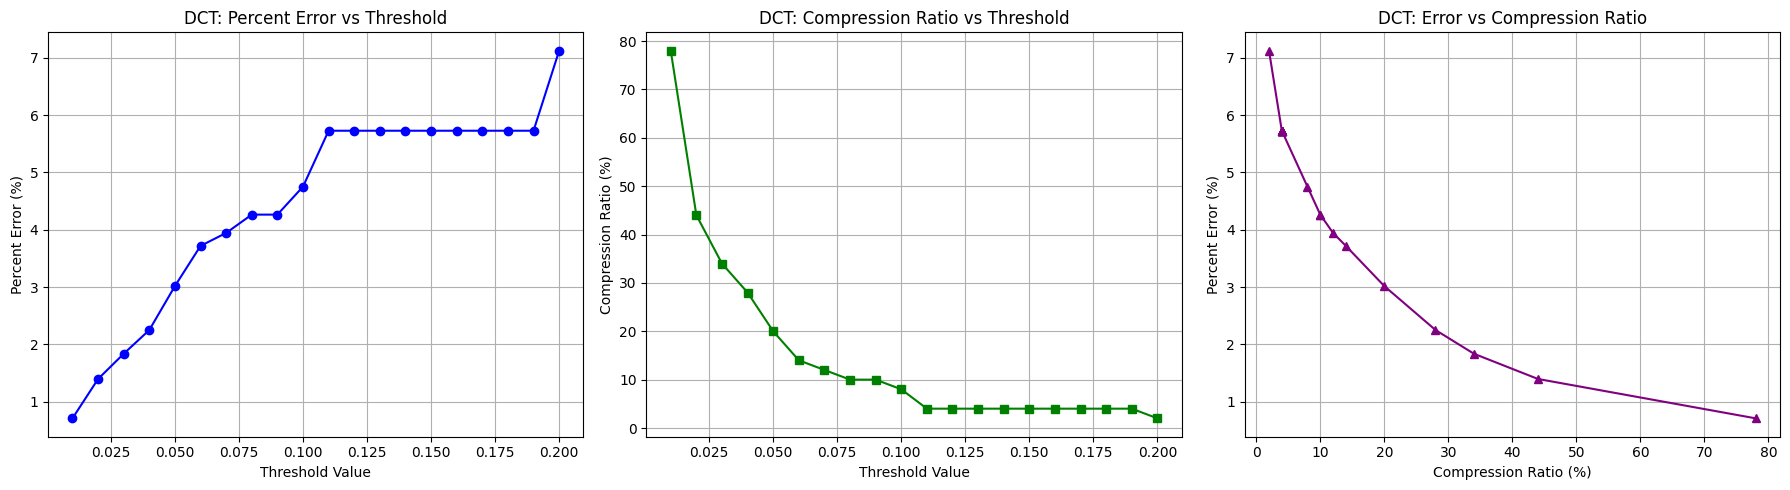

In [ ]:
from scipy.fftpack import dct, idct
import numpy as np
import matplotlib.pyplot as plt

def dct_compress_threshold(A, threshold):
    """
    Compress a 2D matrix using the DCT by zeroing out small DCT coefficients.

    Parameters:
    - A: 2D NumPy array (e.g., image patch or grayscale image)
    - threshold: magnitude cutoff — any DCT coefficient smaller than this is set to zero

    Returns:
    - A_recon: reconstructed matrix using inverse DCT
    - k: number of DCT coefficients retained after thresholding
    - Y_thresh: thresholded DCT coefficient matrix
    """

    # Step 1: Apply 2D DCT (first along rows, then columns)
    # This is equivalent to Y = C A C^T
    Y = dct(dct(A.T, norm='ortho').T, norm='ortho')

    # Step 2: Threshold small DCT coefficients (i.e., discard low-magnitude frequencies)
    Y_thresh = np.where(np.abs(Y) >= threshold, Y, 0)

    # Step 3: Apply inverse 2D DCT to reconstruct an approximation of A
    # This is equivalent to A_recon = C^T Y_thresh C
    A_recon = idct(idct(Y_thresh.T, norm='ortho').T, norm='ortho')

    # Step 4: Count how many DCT coefficients we kept (i.e., nonzero entries)
    k = np.count_nonzero(Y_thresh)

    return A_recon, k, Y_thresh

def compression_ratio_dct(k, n, bytes_per_float=4, bytes_per_index=2):
    """
    Estimate compression ratio based on number of nonzero DCT coefficients.

    Assumes:
    - Each retained coefficient needs 4 bytes to store its value
    - Each coefficient's (row, col) position needs 2 bytes per index
    """

    # Total size of the original (uncompressed) matrix in bytes
    original_bytes = n * n * bytes_per_float

    # Each retained DCT coefficient requires:
    # - 4 bytes for the value
    # - 4 bytes for its (row, col) position = 2 * 2 bytes
    compressed_bytes = k * (bytes_per_float + 2 * bytes_per_index)

    # Compression ratio = compressed size / original size
    return compressed_bytes / original_bytes

# Step 5: Sweep through a range of thresholds to evaluate error vs compression tradeoff
thresholds = np.linspace(0.01, 0.2, 20)  # Try 20 different thresholds
errors_percent_dct = []      # Percent error for each threshold
compression_ratios_dct = []  # Compression ratio for each threshold

for t in thresholds:
    A_k, k_retained, Y_thresh = dct_compress_threshold(A, threshold=t)

    # Compute percent reconstruction error (normalized Frobenius norm)
    error = np.linalg.norm(A - A_k, 'fro')
    errors_percent_dct.append(100 * error / fro_norm_A)

    # Compute estimated compression ratio based on bytes
    cr = compression_ratio_dct(k_retained, A.shape[0])
    compression_ratios_dct.append(100 * cr)  # scale to percentage

# Step 6: Plot results

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Percent error vs threshold
axs[0].plot(thresholds, errors_percent_dct, marker='o', color='blue')
axs[0].set_title('DCT: Percent Error vs Threshold')
axs[0].set_xlabel('Threshold Value')
axs[0].set_ylabel('Percent Error (%)')
axs[0].grid(True)

# Plot 2: Compression ratio vs threshold
axs[1].plot(thresholds, compression_ratios_dct, marker='s', color='green')
axs[1].set_title('DCT: Compression Ratio vs Threshold')
axs[1].set_xlabel('Threshold Value')
axs[1].set_ylabel('Compression Ratio (%)')
axs[1].grid(True)

# Plot 3: Error vs compression ratio
axs[2].plot(compression_ratios_dct, errors_percent_dct, marker='^', color='purple')
axs[2].set_title('DCT: Error vs Compression Ratio')
axs[2].set_xlabel('Compression Ratio (%)')
axs[2].set_ylabel('Percent Error (%)')
axs[2].grid(True)

plt.tight_layout()
plt.show()


### Interpreting the DCT Compression Results

These plots illustrate how thresholding small DCT coefficients affects reconstruction accuracy and compression efficiency:

- **Left plot**: As we increase the threshold, more DCT coefficients are discarded, and the reconstruction error rises. Most of the error increase occurs between thresholds of 0.02 and 0.10, after which it flattens out. This means that many of the remaining coefficients beyond that point contribute very little to the reconstruction.

- **Middle plot**: The compression ratio improves rapidly at first — small increases in the threshold eliminate a large number of small-valued coefficients. But, similar to the LU results, there's a point where most insignificant coefficients have already been removed, and additional thresholding yields only minor compression gains.

- **Right plot**: This shows the overall trade-off between compression and accuracy. DCT performs quite well here: a modest error (~2–3%) can be achieved while retaining only a small portion of the original data. The smooth curve reflects the fact that the DCT tends to concentrate most of a signal’s energy in the first few coefficients, especially for smooth or structured matrices.

---

### Summary

Unlike LU and SVD, the DCT uses a **fixed set of basis vectors** (cosines), which makes it computationally efficient and ideal for real-time or hardware-accelerated applications like image and audio compression. Although it may not always match SVD's optimal accuracy for a given rank, it often delivers **a strong balance between speed and performance**, especially when working with smooth data.

---


# 📚 Final Comparison: LU, SVD, DCT


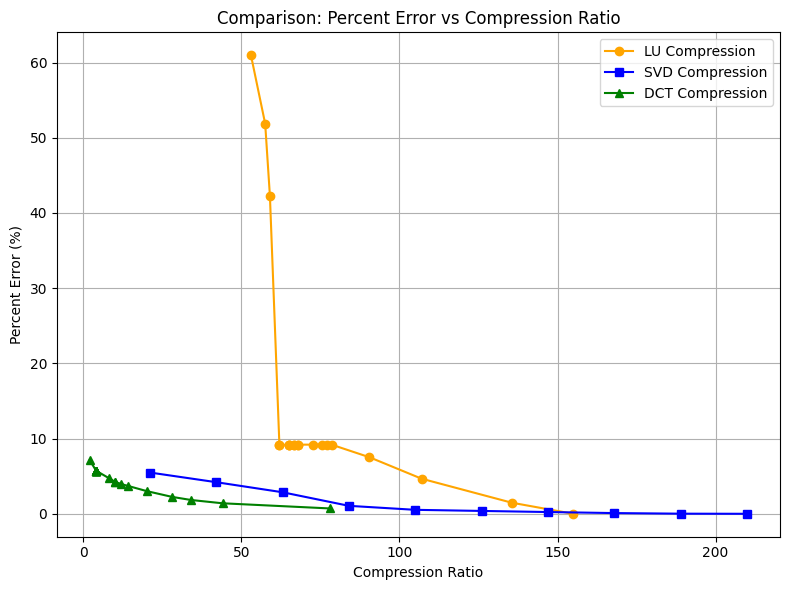

In [31]:

plt.figure(figsize=(8,6))
plt.plot(compression_ratios_lu, errors_percent_lu, marker='o', label='LU Compression', color='orange')
plt.plot(compression_ratios_svd, errors_percent_svd, marker='s', label='SVD Compression', color='blue')
plt.plot(compression_ratios_dct, errors_percent_dct, marker='^', label='DCT Compression', color='green')
plt.title('Comparison: Percent Error vs Compression Ratio')
plt.xlabel('Compression Ratio')
plt.ylabel('Percent Error (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpreting the Compression Comparison

This final plot compares the performance of LU, SVD, and DCT methods in terms of **reconstruction error vs. compression ratio** — that is, how much error we incur when we store only part of the original matrix.

A lower point on the plot (bottom-left) is better: it means **less error** for a **smaller storage footprint**.

#### Key Observations:

- **DCT** (green line): Delivers the **best overall compression efficiency**. It achieves low reconstruction error while using a small fraction of the original storage. This is because DCT concentrates signal energy into a small number of coefficients and avoids the cost of storing full basis matrices.

- **SVD** (blue line): While mathematically optimal for low-rank approximation, the storage cost of SVD is high — especially for small to medium matrices — since it requires storing the singular values *and* two full orthogonal matrices. It gives excellent accuracy, but its compression ratio is often worse than DCT for comparable error.

- **LU** (orange line): Performs poorly for compression. Even after thresholding small values, LU incurs relatively high error and requires more storage than the original matrix in many cases. It’s included here mostly as a point of contrast — LU is designed for solving linear systems, not compressing data.

---

### Comparison Table (Compression-Focused)

| Method | Compression Strategy       | Accuracy per Byte | Storage Efficiency | When to Use                                           |
|--------|----------------------------|--------------------|--------------------|--------------------------------------------------------|
| **LU** | Threshold small values in $L$, $U$ | Low (high error)     | Inefficient (often >100%) | Not recommended for compression; useful for linear solvers |
| **SVD**| Keep top-$k$ singular values + basis | High (best per rank) | Costly (basis storage dominates) | When you need high accuracy and can afford the space     |
| **DCT**| Threshold small DCT coefficients    | Very good            | Excellent (no basis to store)  | Fast, effective compression for smooth/structured data |

---

### Final Thoughts

If you're focused on minimizing storage while preserving signal quality, the DCT emerges as a **highly practical choice**. It may not be mathematically optimal like SVD, but it achieves excellent performance at a fraction of the storage cost — especially for matrices that represent smooth signals or image-like content.

SVD still has value when precision is paramount, and LU serves as a useful baseline for comparison.

